In [60]:
import jax.numpy as jnp
from syuron import shg, mgoslt, pp

# 50000ドメインにするとこれがないと計算がずれてsincじゃない形になったので必要
from jax import config
config.update("jax_enable_x64", True)

PERIOD = 7.2  # グレーティング周期
KAPPA = 1.031E-05
TEMP = 70
DEVICE_LENGTH = 5000  # デバイス長
PERIOD = 7.2  # グレーティング周期
DOMAIN_WIDTH = PERIOD/2

WAVELENGTH_RANGE = jnp.linspace(1.025, 1.037, 1000).tolist()  # 中心波長1030nm周辺

# (2, 1388, 2)で、([structure1, structure2], [...domains], [幅, 符号がついたkappa値])
structure = pp.fixed(
    int(DEVICE_LENGTH/DOMAIN_WIDTH), [DOMAIN_WIDTH, DOMAIN_WIDTH], KAPPA
)

# structure[1, :, 1]で、2番目の構造とkappa値のindexを指定
# int(len * 0.165)以降の符号をすべて反転
idx = int(structure.shape[1] * 0.165)
structure = structure.at[1, idx:, 1].set(-structure[1, idx:, 1])

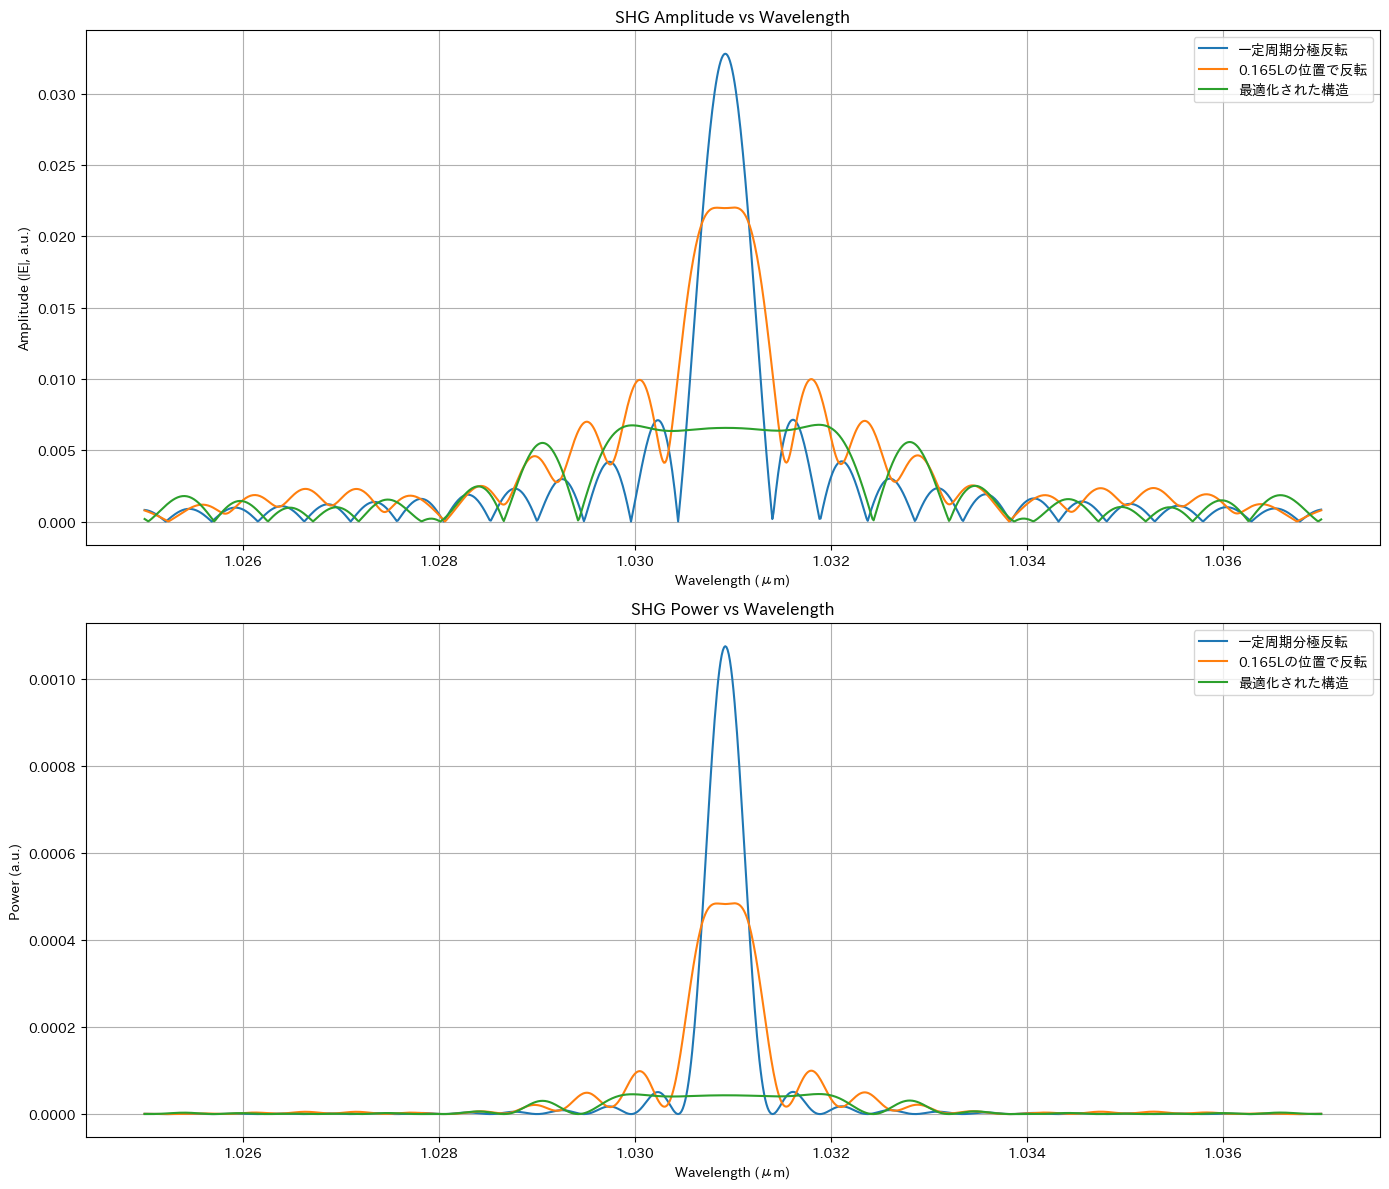

In [61]:
import matplotlib.pyplot as plt
# --- 最適化信号の処理と構造化 --- #

# 定数の定義
NUM_DOMAINS = int(DEVICE_LENGTH / DOMAIN_WIDTH)  # 1388
POINTS_PER_DOMAIN = 36  # 1ドメインあたりの信号点数 (50000 / 1388 の整数部)
TOTAL_POINTS = NUM_DOMAINS * POINTS_PER_DOMAIN  # 49968

# 最適化された信号をロード
optimized_signal = jnp.load("optimized_const_signal_3.npy")

# 信号を(1388, 36)の形状に整形
signal_reshaped = jnp.reshape(
    optimized_signal[:TOTAL_POINTS], (NUM_DOMAINS, POINTS_PER_DOMAIN))

# 各ドメインの符号を決定 (最初の点の符号を代表とする)
domain_signs = signal_reshaped[:, 0]

# 最適化構造を組み立てる
# 1列目: ドメイン幅 (すべて一定)
optimized_widths = jnp.full((NUM_DOMAINS,), DOMAIN_WIDTH)
# 2列目: 符号付きKappa
optimized_kappas = domain_signs * KAPPA
# 結合して (1388, 2) の配列にする
optimized_structure_single = jnp.stack(
    [optimized_widths, optimized_kappas], axis=1)

# --- 解析とプロット --- #

# 既存の構造と新しい最適化構造を結合
# (2, 1388, 2) と (1388, 2) -> (3, 1388, 2) にする
optimized_structure_reshaped = jnp.expand_dims(
    optimized_structure_single, axis=0)  # (1, 1388, 2) に変換
combined_structure = jnp.concatenate(
    [structure, optimized_structure_reshaped], axis=0)

# 解析実行
result_combined = mgoslt.analyze(
    shg.Params(
        grating_dim=combined_structure,
        T_dim=TEMP,
        wavelength_dim=WAVELENGTH_RANGE,
        fund_power_dim=1
    )
)


# power_combined: intensity (|E|^2)
power_combined = (jnp.abs(result_combined)**2).squeeze()
# power_combined_sqrt: amplitude (|E|)
power_combined_sqrt = jnp.abs(result_combined).squeeze()

fig, axs = plt.subplots(2, 1, figsize=(14, 12))

# Amplitude plot
axs[0].plot(WAVELENGTH_RANGE, power_combined_sqrt[0],
            label="一定周期分極反転", color="tab:blue")
axs[0].plot(WAVELENGTH_RANGE, power_combined_sqrt[1],
            label="0.165Lの位置で反転", color="tab:orange")
axs[0].plot(WAVELENGTH_RANGE, power_combined_sqrt[2],
            label="最適化された構造", color="tab:green")
axs[0].set_xlabel("Wavelength (μm)")
axs[0].set_ylabel("Amplitude (|E|, a.u.)")
axs[0].set_title("SHG Amplitude vs Wavelength")
axs[0].grid(True)
axs[0].legend()

# Power plot
axs[1].plot(WAVELENGTH_RANGE, power_combined[0],
            label="一定周期分極反転", color="tab:blue")
axs[1].plot(WAVELENGTH_RANGE, power_combined[1],
            label="0.165Lの位置で反転", color="tab:orange")
axs[1].plot(WAVELENGTH_RANGE, power_combined[2],
            label="最適化された構造", color="tab:green")
axs[1].set_xlabel("Wavelength (μm)")
axs[1].set_ylabel("Power (a.u.)")
axs[1].set_title("SHG Power vs Wavelength")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()